In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
from scipy.ndimage import gaussian_filter
from astropy.stats import mad_std
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
import os
from astropy.table import Table
from make_cuts import choosef, random_apers, get_names, radec_minmax, cuts

#from astroML.plotting import MultiAxes
from scipy.optimize import curve_fit

In [10]:
data_c = Table.read("NSF1_Bagpipes_NO_AGN.fits")

In [11]:
data_c

NUMBER_1,FLUX_ISO_1,FLUXERR_ISO_1,MAG_ISO_1,MAGERR_ISO_1,FLUX_APER_1 [13],FLUXERR_APER_1 [13],MAGERR_APER_1 [13],MAG_APER_1 [13],FLUX_AUTO_1,FLUXERR_AUTO_1,MAG_AUTO_1,MAGERR_AUTO_1,BACKGROUND_1,ALPHAPEAK_J2000_1,DELTAPEAK_J2000_1,X_IMAGE_1,Y_IMAGE_1,ALPHA_J2000_1,DELTA_J2000_1,FLAGS_1,ELONGATION_1,ELLIPTICITY_1,CLASS_STAR_1,FLUX_RADIUS_1,SNR_WIN_1,MAG_APER_g_1 [13],FLUX_APER_g_1 [13],FLUXERR_APER_g_1 [13],MAGERR_APER_g_1 [13],MAGERR_AUTO_g_1,BACKGROUND_g_1,MAG_AUTO_g_1,MAG_APER_r_1 [13],FLUX_APER_r_1 [13],FLUXERR_APER_r_1 [13],MAGERR_APER_r_1 [13],MAGERR_AUTO_r_1,BACKGROUND_r_1,MAG_AUTO_r_1,MAG_APER_i_1 [13],FLUX_APER_i_1 [13],FLUXERR_APER_i_1 [13],MAGERR_APER_i_1 [13],MAGERR_AUTO_i_1,BACKGROUND_i_1,MAG_AUTO_i_1,MAG_APER_z_1 [13],FLUX_APER_z_1 [13],FLUXERR_APER_z_1 [13],MAGERR_APER_z_1 [13],MAGERR_AUTO_z_1,BACKGROUND_z_1,MAG_AUTO_z_1,MAG_APER_y_1 [13],FLUX_APER_y_1 [13],FLUXERR_APER_y_1 [13],MAGERR_APER_y_1 [13],MAGERR_AUTO_y_1,BACKGROUND_y_1,MAG_AUTO_y_1,NUMBER_2,FLUX_ISO_2,FLUXERR_ISO_2,MAG_ISO_2,MAGERR_ISO_2,FLUX_APER_2 [13],FLUXERR_APER_2 [13],MAGERR_APER_2 [13],MAG_APER_2 [13],FLUX_AUTO_2,FLUXERR_AUTO_2,MAG_AUTO_2,MAGERR_AUTO_2,BACKGROUND_2,ALPHAPEAK_J2000_2,DELTAPEAK_J2000_2,X_IMAGE_2,Y_IMAGE_2,ALPHA_J2000_2,DELTA_J2000_2,FLAGS_2,ELONGATION_2,ELLIPTICITY_2,CLASS_STAR_2,FLUX_RADIUS_2,SNR_WIN_2,MAG_APER_g_2 [13],FLUX_APER_g_2 [13],FLUXERR_APER_g_2 [13],MAGERR_APER_g_2 [13],MAGERR_AUTO_g_2,BACKGROUND_g_2,MAG_AUTO_g_2,MAG_APER_r_2 [13],FLUX_APER_r_2 [13],FLUXERR_APER_r_2 [13],MAGERR_APER_r_2 [13],MAGERR_AUTO_r_2,BACKGROUND_r_2,MAG_AUTO_r_2,MAG_APER_i_2 [13],FLUX_APER_i_2 [13],FLUXERR_APER_i_2 [13],MAGERR_APER_i_2 [13],MAGERR_AUTO_i_2,BACKGROUND_i_2,MAG_AUTO_i_2,MAG_APER_z_2 [13],FLUX_APER_z_2 [13],FLUXERR_APER_z_2 [13],MAGERR_APER_z_2 [13],MAGERR_AUTO_z_2,BACKGROUND_z_2,MAG_AUTO_z_2,MAG_APER_y_2 [13],FLUX_APER_y_2 [13],FLUXERR_APER_y_2 [13],MAGERR_APER_y_2 [13],MAGERR_AUTO_y_2,BACKGROUND_y_2,MAG_AUTO_y_2,Separation,#ID,burst:age_16,burst:age_50,burst:age_84,burst:massformed_16,burst:massformed_50,burst:massformed_84,burst:metallicity_16,burst:metallicity_50,burst:metallicity_84,redshift_16,redshift_50,redshift_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4034,27.845892,1.8776053,23.388098,0.073227294,8.3005

In [4]:
#mask_a = (data_a['CHI_BEST'] >10) & (data_a['CHI_BEST']< 1000000000.0)

In [12]:
mask_3 =  (1.4563703228014209 < data_c['redshift_50']) & (data_c['redshift_50'] < 1.8553277139269122)
#mask3 = (1.25 < table['Z_BEST'] ) & (table['Z_BEST'] < 2)
data_a = data_c[mask_3]

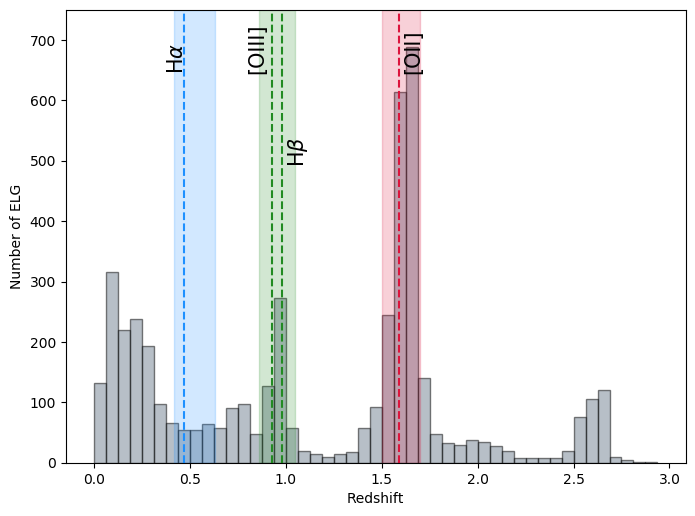

In [14]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(data_c['redshift_50'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.42, 0.63, alpha=0.2, color='dodgerblue')
ax.text(0.38, 650, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(0.8, 650, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.5, 1.7, alpha=0.2, color='crimson')
ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

In [16]:
aper =2
g = np.array([data_a['FLUX_APER_g_1'][i][aper] for i in range(len(data_a))])

r = np.array([data_a['FLUX_APER_r_1'][i][aper] for i in range(len(data_a))])

i = np.array([data_a['FLUX_APER_i_1'][i][aper] for i in range(len(data_a))])

z = np.array([data_a['FLUX_APER_z_1'][i][aper] for i in range(len(data_a))])

y = np.array([data_a['FLUX_APER_y_1'][i][aper] for i in range(len(data_a))])

NB = np.array([data_a['FLUX_APER_1'][i][aper] for i in range(len(data_a))])

g_err = np.array([data_a['FLUXERR_APER_g_1'][i][aper] for i in range(len(data_a))])

r_err = np.array([data_a['FLUXERR_APER_r_1'][i][aper] for i in range(len(data_a))])

i_err = np.array([data_a['FLUXERR_APER_i_1'][i][aper] for i in range(len(data_a))])

z_err = np.array([data_a['FLUXERR_APER_z_1'][i][aper] for i in range(len(data_a))])

y_err = np.array([data_a['FLUXERR_APER_y_1'][i][aper] for i in range(len(data_a))])

NB_err = np.array([data_a['FLUXERR_APER_1'][i][aper] for i in range(len(data_a))])

NSF_NB = fits.open('Fields/nsf_nb964_sci.fits')
data_NB = NSF_NB[1].data
hdr_NB = NSF_NB[1].header

NSF_g = fits.open('Fields/nsf_g_sci.fits')
data_g = NSF_g[1].data
hdr_g = NSF_g[1].header

NSF_r = fits.open('Fields/nsf_r_sci.fits')
data_r = NSF_r[1].data
hdr_r = NSF_r[1].header

NSF_i = fits.open('Fields/nsf_i_sci.fits')
data_i = NSF_i[1].data
hdr_i = NSF_i[1].header

NSF_z = fits.open('Fields/nsf_z_sci.fits')
data_z = NSF_z[1].data
hdr_z = NSF_z[1].header

NSF_y = fits.open('Fields/nsf_y_sci.fits')
data_y = NSF_y[1].data
hdr_y = NSF_y[1].header


info = pd.read_csv('Fields.txt', sep = " ")

In [17]:
np.max(NB)

1893.5281

In [18]:
def cuts_mult(coords, data_filters, hdr_filters, names_filters, flux_filters, flux_errors, size, field):

    #data_filters = datag,datar,datai,dataz,datay, datanb
    #hdr_filters = hdrg, hdrr, hdri, hdrz, hdry, hdrnb
    # el path en el cual guardaremos las imágenes
    path = os.path.join('Cutouts', str(field))

    sigmac = []
    
                
    for j in range(len(data_filters)):        
        aper = random_apers(data_filters[j])
        sums = aper['aperture_sum']
        clipped = sigma_clipped_stats(sums, sigma=2)
        sigmac_ = clipped[2]
        sigmac.append(sigmac_)

    print(sigmac)
    names = get_names(coords)  # función amanda

    for i in range(len(coords)):

        path_N = os.path.join(path, str(i))

        fig =plt.figure(figsize=(16,10))
        #X = [ (2,1,1),(2,5,6), (2,5,7), (2,5,8) , (2,5,9) , (2,5,10)]
        X = [ [2,1,1],[2,6,7], [2,6,8] , [2,6,9] , [2,6,10], [2,6,11],[2,6,12]]
        
        ax= fig.add_subplot(2,1,1)
        pivot = np.array([4770.80, 6371.30, 7774.20, 9157.90, 9640.00, 9886.30]) #g,r,i,z,NB,y,
        lines = np.array([flux_filters[j][i] for j in range(6)])
        err = np.array([flux_errors[j][i] for j in range(6)])
        #ax.errorbar(pivot[0], flux_filters[0][i], yerr=(errx,erry), fmt='.')
        
        for j, piv in enumerate(pivot):
            ax.errorbar(piv, lines[j], yerr = err[j], label = names_filters[j], fmt='o', capsize=2, ms=5, elinewidth=1)

        #ax.set_title(str(flux_filters[4][i]))
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Flux')
        ax.set_title("ID: "+ str(i))
        
        ax.plot(pivot,lines, linestyle = 'dashed', color = 'slategray')
        plt.legend(loc =2)
        # print(path_N)
        
        for x, plot_data in enumerate(X[1:]):
            nrows, ncols, plot_number = plot_data[0], plot_data[1], plot_data[2]
            
            ax= fig.add_subplot(nrows, ncols, plot_number)
            data = data_filters[x]
            #x = k
            #sub.set_xticks([])
            #sub.set_yticks([]) 
        #for x, data in enumerate(data_filters):

                # nos retorna la desviación estandar que ocuparemos para que se vean bien los lya en los recortes
           # print(x,(x+1)//5, x-((x+1)//5 *5))
            m_wcs = WCS(hdr_filters[x])
            c = SkyCoord(coords[i][0], coords[i][1], frame=FK5, unit="deg")
            recorte = Cutout2D(
                data, c, (size*u.arcsec, size*u.arcsec), wcs=m_wcs)
            im = (recorte.data)
#ax[(x)//5, x-((x)//5 * 5)]
            ax.imshow(im, origin='lower', interpolation='nearest',
                                              cmap='Greys', vmin=-1*sigmac[x], vmax=3*sigmac[x])  # , norm = norm)
#             ax.scatter((len(recorte.data)/2),len(recorte.data)/2-3, marker='|', color='red', s=300)
#             ax.scatter((len(recorte.data)/2) -5, len(recorte.data)/2, marker='_', color='red', s=300)
            ax.set_title(names_filters[x], fontsize=18)
            ax.axis('off')

#         ax[1, 1].set_axis_off()
#         ax[1, 2].set_axis_off()
#         ax[1, 3].set_axis_off()
#         ax[1, 4].set_axis_off()

        plt.savefig(path_N, transparent=False, facecolor='white')
        fig.tight_layout()
        plt.show()
        


    return

In [28]:
mask2 =  NB > 320
data_H2 = data_a[mask2]
len(data_H2)

10

In [29]:
RA_ = data_H2['ALPHA_J2000_1']
DEC_ = data_H2['DELTA_J2000_1']

In [30]:
aper =2
g = np.array([data_H2['FLUX_APER_g_1'][i][aper] for i in range(len(data_H2))])

r = np.array([data_H2['FLUX_APER_r_1'][i][aper] for i in range(len(data_H2))])

i = np.array([data_H2['FLUX_APER_i_1'][i][aper] for i in range(len(data_H2))])

z = np.array([data_H2['FLUX_APER_z_1'][i][aper] for i in range(len(data_H2))])

y = np.array([data_H2['FLUX_APER_y_1'][i][aper] for i in range(len(data_H2))])

NB = np.array([data_H2['FLUX_APER_1'][i][aper] for i in range(len(data_H2))])

g_err = np.array([data_H2['FLUXERR_APER_g_1'][i][aper] for i in range(len(data_H2))])

r_err = np.array([data_H2['FLUXERR_APER_r_1'][i][aper] for i in range(len(data_H2))])

i_err = np.array([data_H2['FLUXERR_APER_i_1'][i][aper] for i in range(len(data_H2))])

z_err = np.array([data_H2['FLUXERR_APER_z_1'][i][aper] for i in range(len(data_H2))])

y_err = np.array([data_H2['FLUXERR_APER_y_1'][i][aper] for i in range(len(data_H2))])

NB_err = np.array([data_H2['FLUXERR_APER_1'][i][aper] for i in range(len(data_H2))])

[0.23755644727625289, 0.2541552367085136, 0.23430637821031605, 0.442206265929698, 0.9465725049355155, 1.0693204143199302]


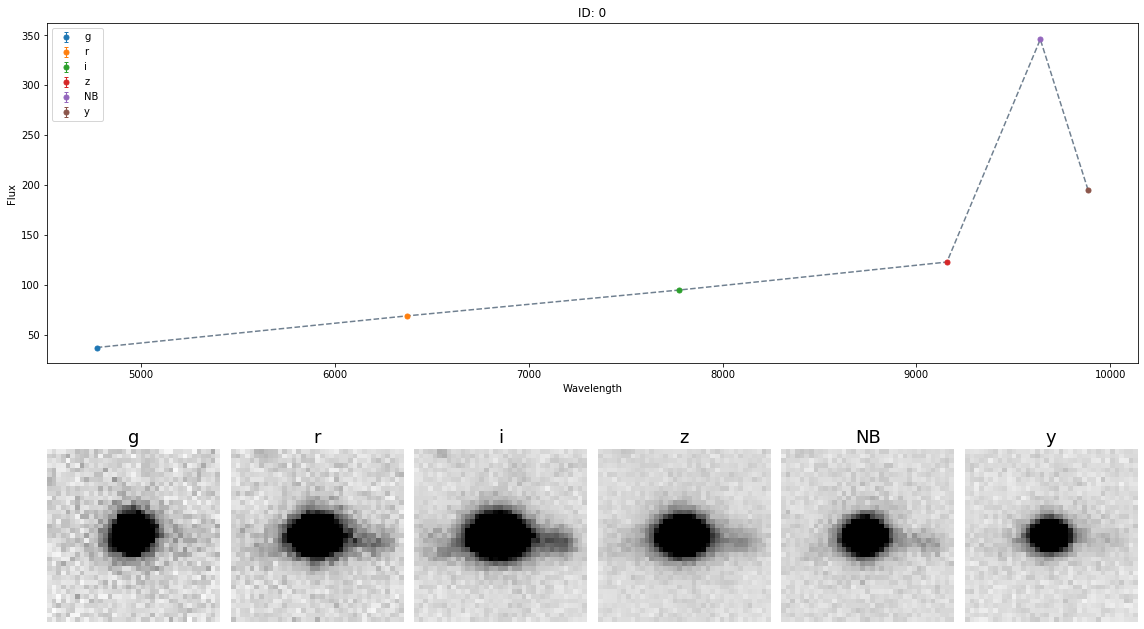

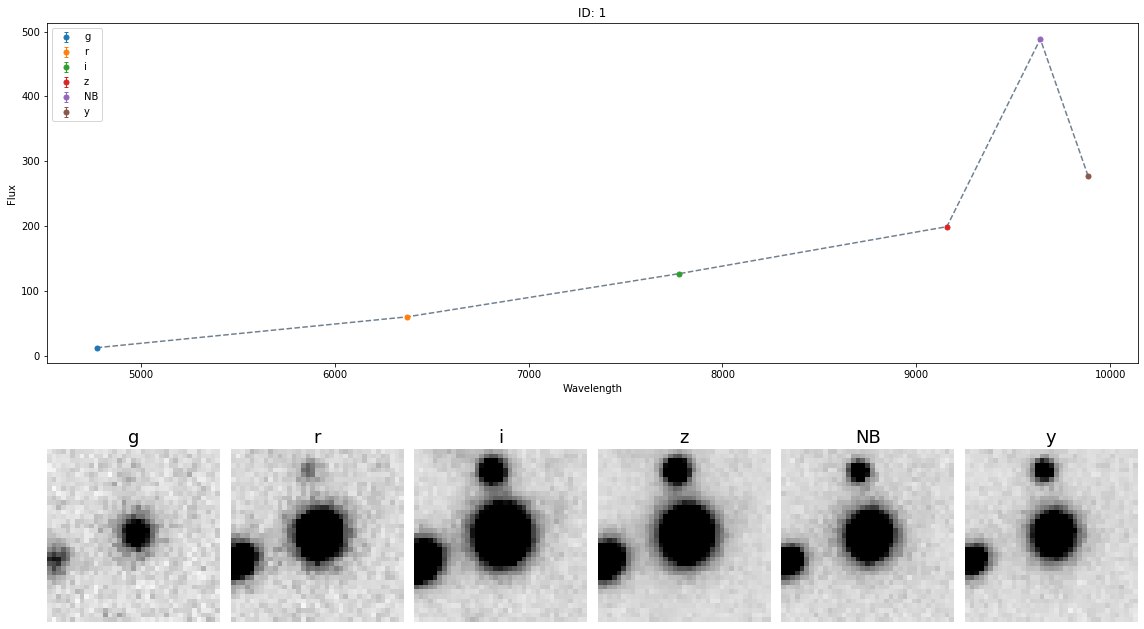

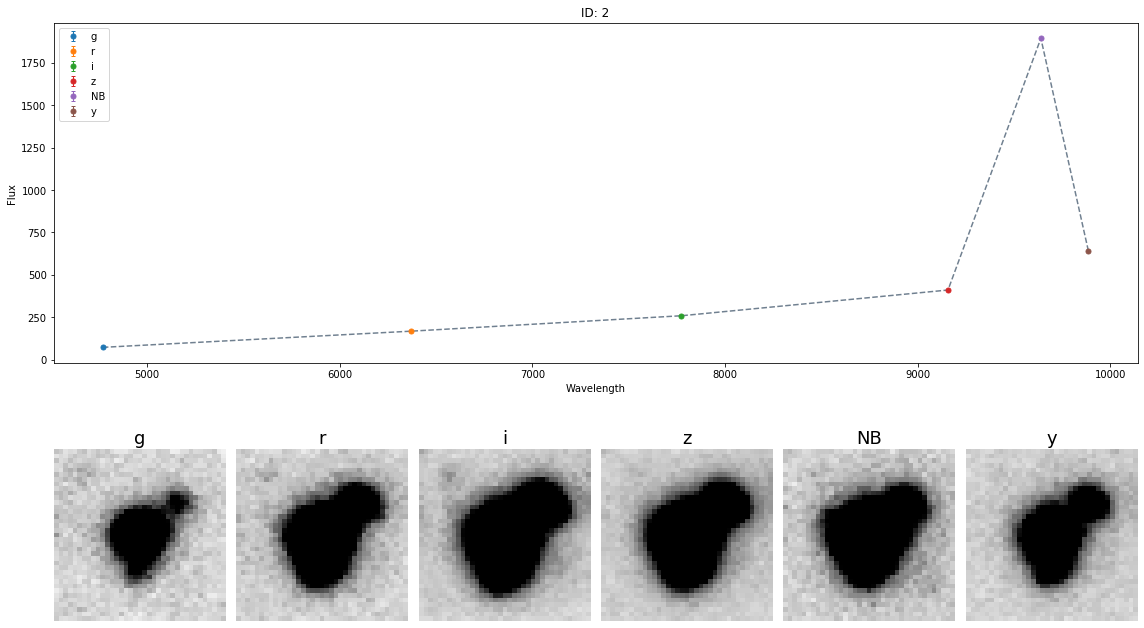

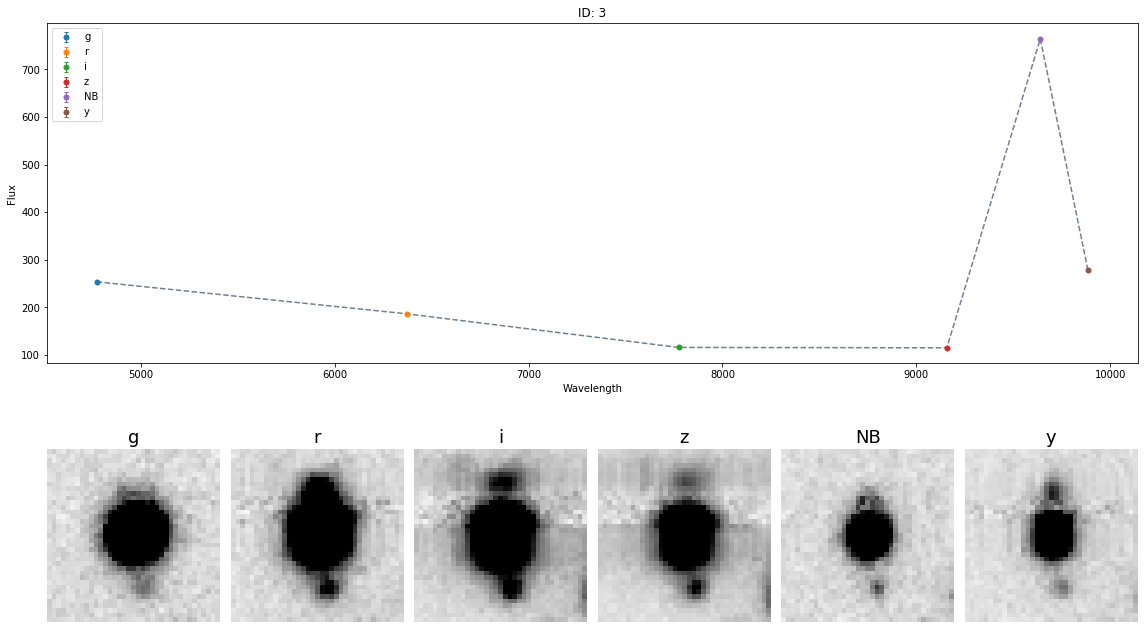

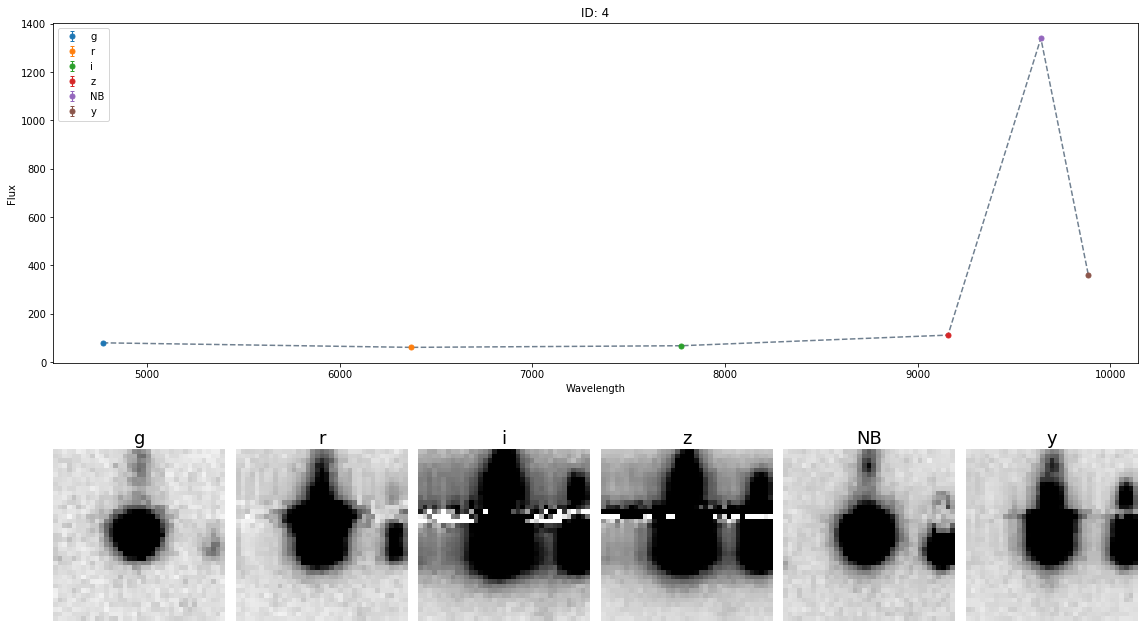

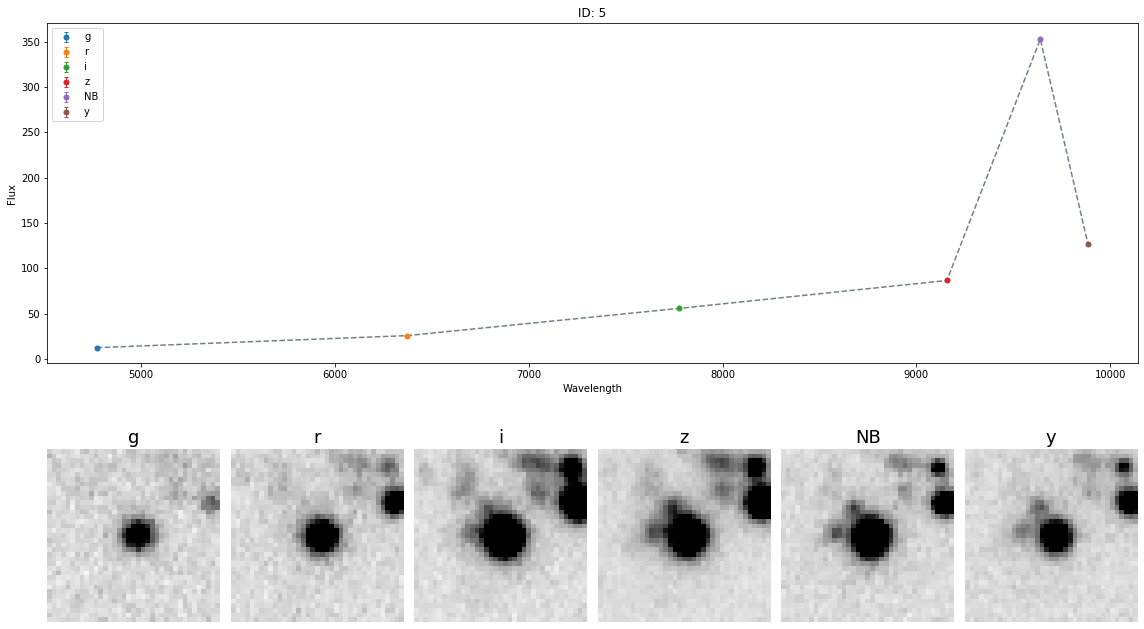

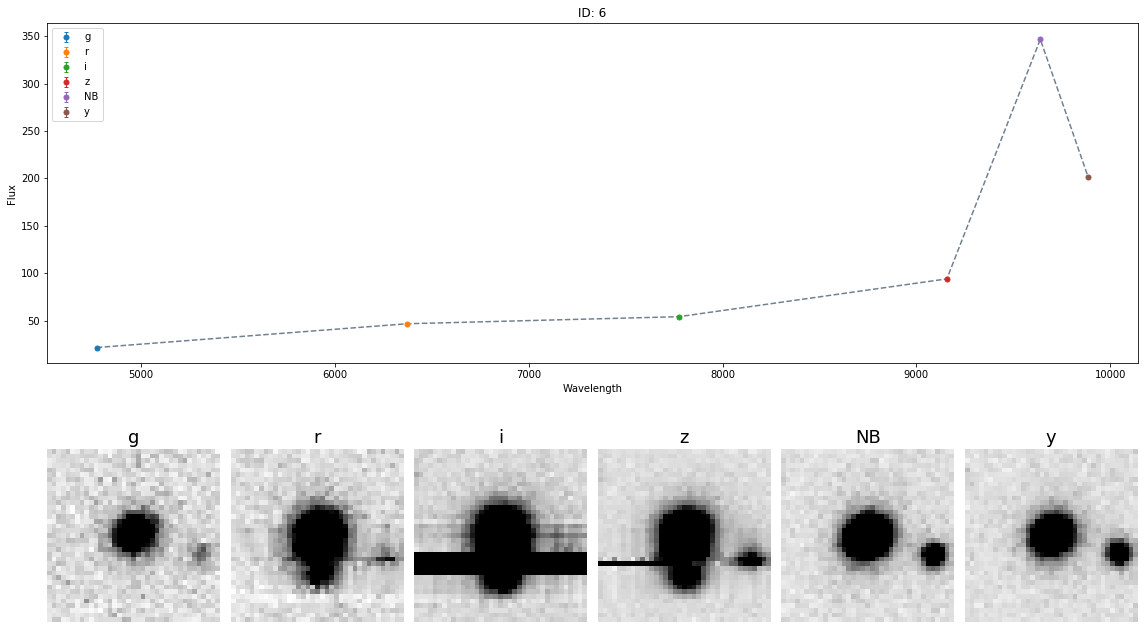

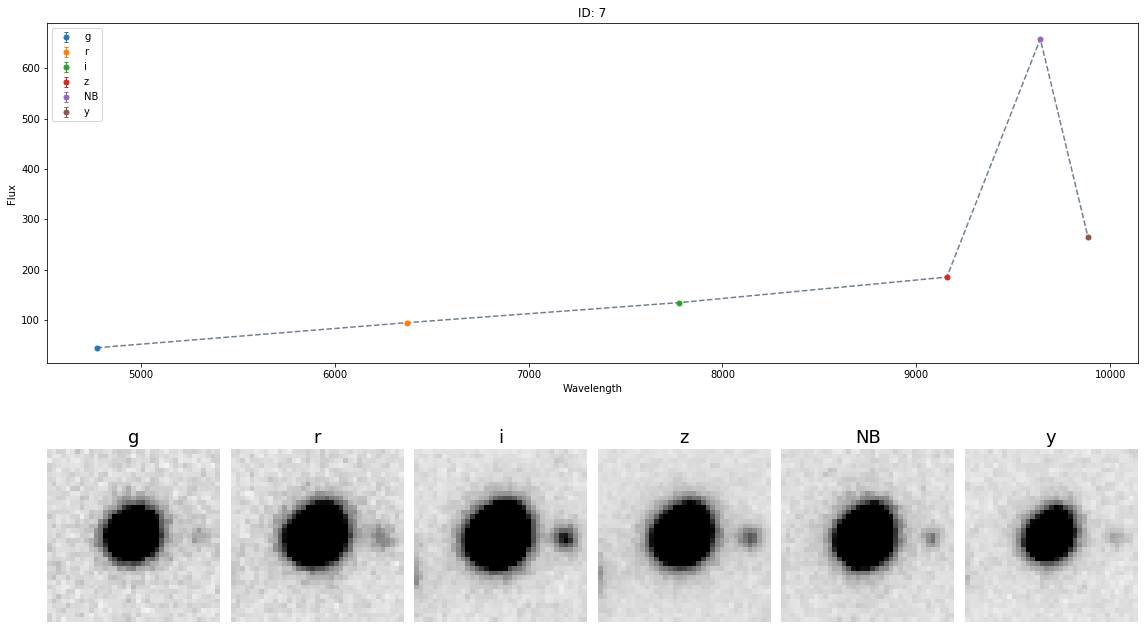

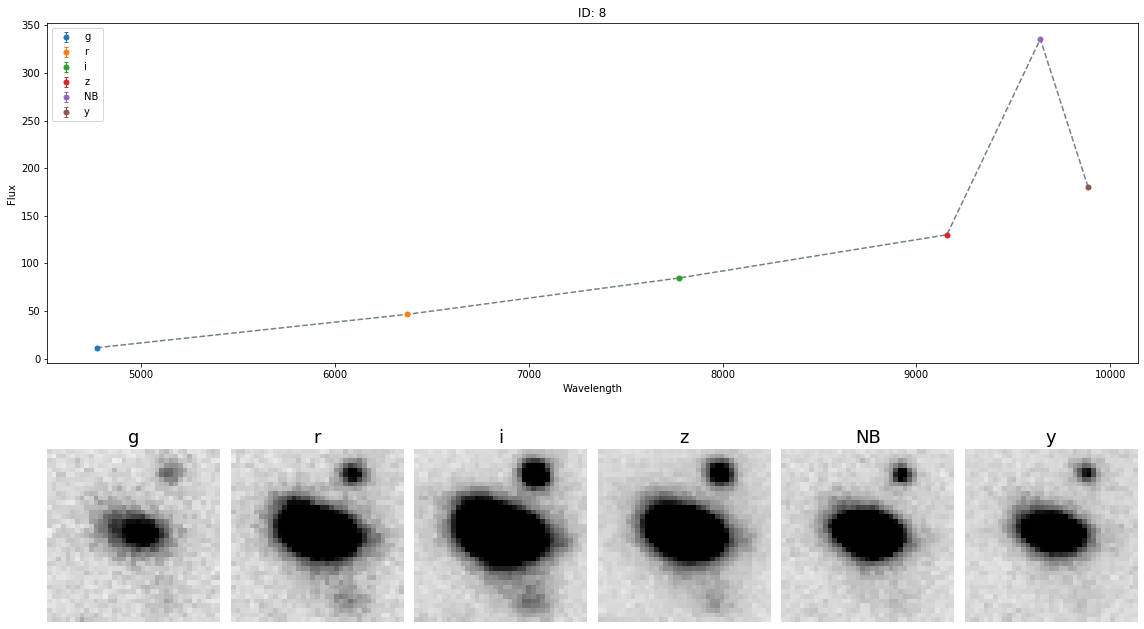

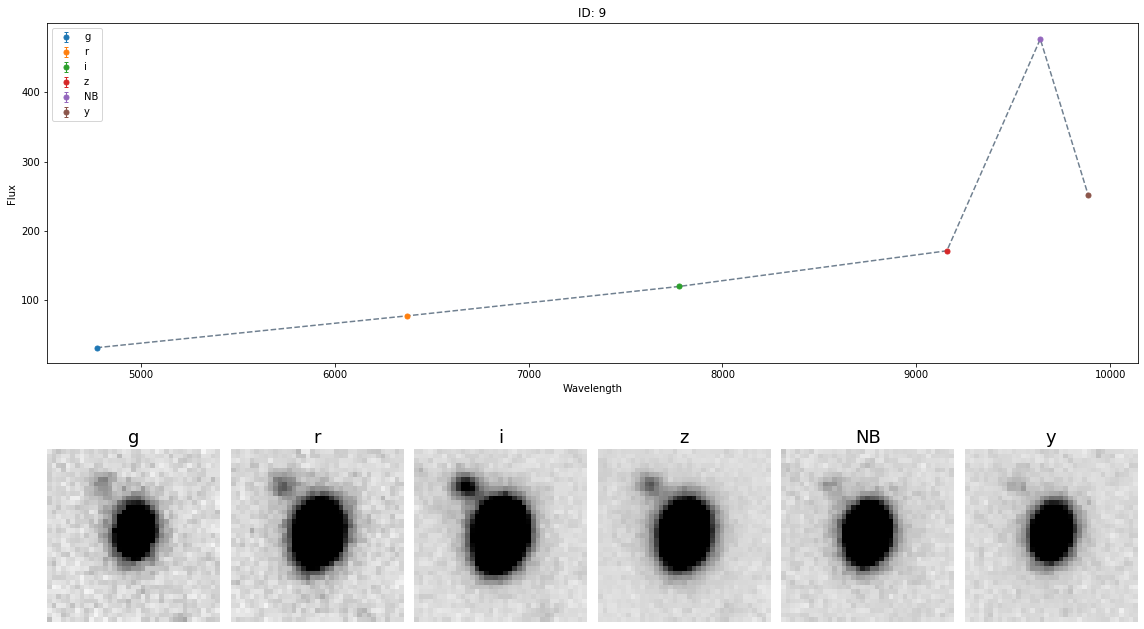

In [31]:
nsf_id = choosef(RA_,DEC_,info)
data_filters = [data_g, data_r, data_i, data_z,data_NB, data_y]
hdr_filters = [hdr_g, hdr_r, hdr_i, hdr_z, hdr_NB,hdr_y]
names_filters = ['g', 'r', 'i', 'z', 'NB', 'y']
flux_filters = [g,r,i,z,NB,y]
flux_errors = [g_err,r_err,i_err,z_err,NB_err,y_err]
NSF_cutm = cuts_mult(nsf_id, data_filters, hdr_filters, names_filters,flux_filters, flux_errors, 10, 'Stamps_ELG')

In [32]:
data_H2

NUMBER_1,FLUX_ISO_1,FLUXERR_ISO_1,MAG_ISO_1,MAGERR_ISO_1,FLUX_APER_1 [13],FLUXERR_APER_1 [13],MAGERR_APER_1 [13],MAG_APER_1 [13],FLUX_AUTO_1,FLUXERR_AUTO_1,MAG_AUTO_1,MAGERR_AUTO_1,BACKGROUND_1,ALPHAPEAK_J2000_1,DELTAPEAK_J2000_1,X_IMAGE_1,Y_IMAGE_1,ALPHA_J2000_1,DELTA_J2000_1,FLAGS_1,ELONGATION_1,ELLIPTICITY_1,CLASS_STAR_1,FLUX_RADIUS_1,SNR_WIN_1,MAG_APER_g_1 [13],FLUX_APER_g_1 [13],FLUXERR_APER_g_1 [13],MAGERR_APER_g_1 [13],MAGERR_AUTO_g_1,BACKGROUND_g_1,MAG_AUTO_g_1,MAG_APER_r_1 [13],FLUX_APER_r_1 [13],FLUXERR_APER_r_1 [13],MAGERR_APER_r_1 [13],MAGERR_AUTO_r_1,BACKGROUND_r_1,MAG_AUTO_r_1,MAG_APER_i_1 [13],FLUX_APER_i_1 [13],FLUXERR_APER_i_1 [13],MAGERR_APER_i_1 [13],MAGERR_AUTO_i_1,BACKGROUND_i_1,MAG_AUTO_i_1,MAG_APER_z_1 [13],FLUX_APER_z_1 [13],FLUXERR_APER_z_1 [13],MAGERR_APER_z_1 [13],MAGERR_AUTO_z_1,BACKGROUND_z_1,MAG_AUTO_z_1,MAG_APER_y_1 [13],FLUX_APER_y_1 [13],FLUXERR_APER_y_1 [13],MAGERR_APER_y_1 [13],MAGERR_AUTO_y_1,BACKGROUND_y_1,MAG_AUTO_y_1,NUMBER_2,FLUX_ISO_2,FLUXERR_ISO_2,MAG_ISO_2,MAGERR_ISO_2,FLUX_APER_2 [13],FLUXERR_APER_2 [13],MAGERR_APER_2 [13],MAG_APER_2 [13],FLUX_AUTO_2,FLUXERR_AUTO_2,MAG_AUTO_2,MAGERR_AUTO_2,BACKGROUND_2,ALPHAPEAK_J2000_2,DELTAPEAK_J2000_2,X_IMAGE_2,Y_IMAGE_2,ALPHA_J2000_2,DELTA_J2000_2,FLAGS_2,ELONGATION_2,ELLIPTICITY_2,CLASS_STAR_2,FLUX_RADIUS_2,SNR_WIN_2,MAG_APER_g_2 [13],FLUX_APER_g_2 [13],FLUXERR_APER_g_2 [13],MAGERR_APER_g_2 [13],MAGERR_AUTO_g_2,BACKGROUND_g_2,MAG_AUTO_g_2,MAG_APER_r_2 [13],FLUX_APER_r_2 [13],FLUXERR_APER_r_2 [13],MAGERR_APER_r_2 [13],MAGERR_AUTO_r_2,BACKGROUND_r_2,MAG_AUTO_r_2,MAG_APER_i_2 [13],FLUX_APER_i_2 [13],FLUXERR_APER_i_2 [13],MAGERR_APER_i_2 [13],MAGERR_AUTO_i_2,BACKGROUND_i_2,MAG_AUTO_i_2,MAG_APER_z_2 [13],FLUX_APER_z_2 [13],FLUXERR_APER_z_2 [13],MAGERR_APER_z_2 [13],MAGERR_AUTO_z_2,BACKGROUND_z_2,MAG_AUTO_z_2,MAG_APER_y_2 [13],FLUX_APER_y_2 [13],FLUXERR_APER_y_2 [13],MAGERR_APER_y_2 [13],MAGERR_AUTO_y_2,BACKGROUND_y_2,MAG_AUTO_y_2,Separation,#ID,burst:age_16,burst:age_50,burst:age_84,burst:massformed_16,burst:massformed_50,burst:massformed_84,burst:metallicity_16,burst:metallicity_50,burst:metallicity_84,redshift_16,redshift_50,redshift_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
29511,913.56384,3.2552512,19.598152,0.0038696832,231.